# Constrastive Learning for Sequential Recommendation 논문 리뷰

## 기존 연구 상황

- 학습에서의 항상 어려움 존재 -> Negative Sampling을 통한 Ranking Loss(BPR)학습
- 학습에 도움이 되지 않는 Negative item 보다 Hard Negative가 필요해짐
  
- 잠재적으로 Positive 확률이 높은 item이 Negative sample에 들어가 모델 학습을 방해함

- 각 User 마다 Pos/Neg item은 임베딩된 공간에서 다른 유저에게 잘못된 영향(추천)을 하게됨

## SASRec

- 문제점 : long term 정보 반영과 순차적 정보에서의 유저의 구매 의도 변화 반영 힘들다.
- Transformer 기반의 모델이 해당 문제점을 어느정도 해결하며 SOTA 성능을 내었다.

### SSL

-  Unlabeled data Representatino 방법론
1. Prediction task - image rotation, patch location, colorization 등 pretext task를 통해 학습 / masking, sentence ordering
2. Discrmination tast - Contrastive learnin, 두개의 샘플 비교를 통해 학습, SimCLR, CL4Rex

## CL4Rex

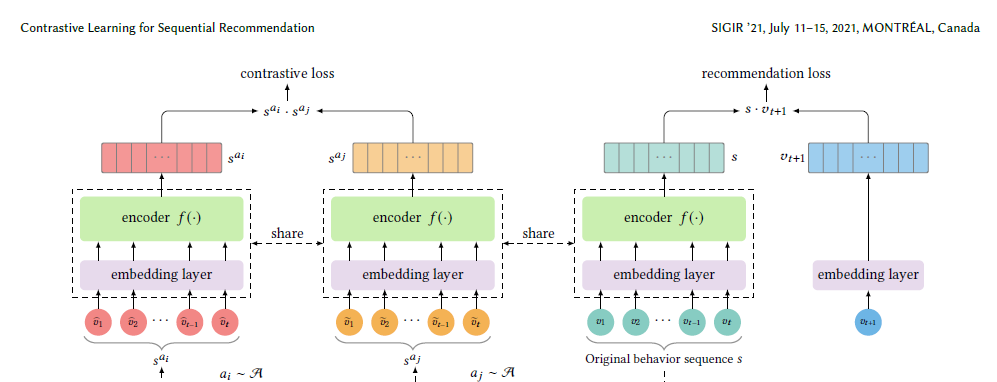

### Embedding Layer

1. Sequence 기준 전 시점의 item을 기준으로 Next item을 예측 -> t-1 시점의 item을 통해 t 시점의 item 예측
2. 길이가 너무 길 경우 : 최근 n개 선택 / 짧을 경우 : n개 전 0 padding
3. 하나의 유저의 history 를 time stamp에 따라 순차 정렬함( 시간을 고려 x , 순서만 고려한다)

- User seq E : Item + Position(learnable)
- 실험적 결과 : Fixed position embedding을 사용 해봤으나 성능이 떨어짐

### Framework

1. Augmentation : 3가지 방식의 기법 활용
2. 각 방식 마다 다른 관점에서 Sequence를 표현하려고 함(Main preference 는 보존된다는 가정을 함)
3. 개/고양이 이미지를 Crop,Rotate해도 그 특징은 보존 된다는 것과 유사

### Augmentation Operator 

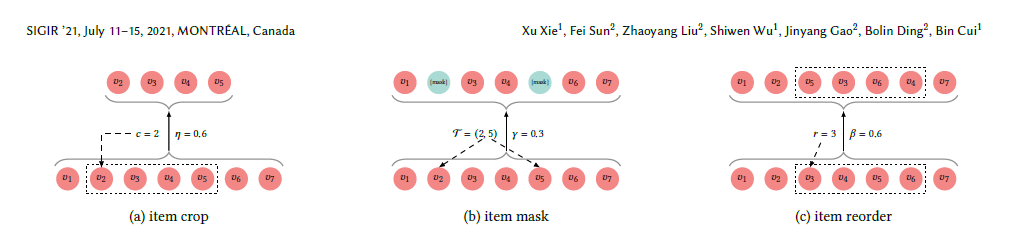

#### item crop
- 전체 길이의 일부 ratio n 만큼 random start point(c)에서 cropping
- 유저의 local preference 학습
- crop 된 sequence가 겹치는 부분이 없다면 모델 입장에서는 유저의 prference가 변하는 것을 예측(학습) 할 수 있다.

#### item mask

- NLP에서 많이 쓰이는 방식
- 유저의 잠재 선호도는 masking을 하여도 유지
- Item의 전체 sequence에는 대표 선호가 좀 더 뚜렷하게 나타남

#### item reorder

- 순서 정보에 의존적이지 않은 방식
- 사람의 Click 정보는 항상 똑같지 않음(외부적 요소가 다량 존재함)
- 순서를 섞어도 User의 잠재의도를 구별해냄
- 새로운 interaction rule에 robust 한 모델

### Transformer Encoder (Uni-direction) -> SASRec 모델 사용
- 단방향으로 진행되는 모델이고 서로 share하는 특징을 가지고 있음

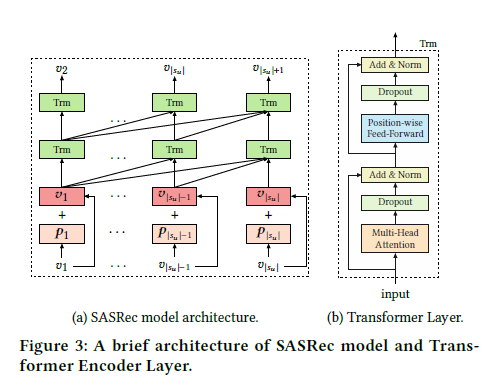

- Dropout : Sequence item index를 통해, item matrix에서 Look up 해올 때, Random 한 비율로 아이템을 가지고 오지 않음(Zero)
- 이는 아이템의 순서에 대한 robust 함을 상승 시키고, 여러 모델을 앙상블 하는 효과와 같다고 함

- Prediction layer : Sequence representation(t 시점에서의 정보)를 통해 t+1 시점의 아이템 예측
- Next item 의 Score값이 높에 나오도록 학습
- Negative interation 이 없는 아이템 중 랜덤 하게 선택
- Contrastive loss : Augmentation 된 Sequence에 똑같은 Transformer layer를 거친 후 나온 결과 값을 통해 loss 산출

### Contrastive Loss Function
- 생성된 두개의 Representation이 같은 유저에서 파생 여부를 구별함

- 배치 마다 사용되는 Augmentation Operation은 랜덤하게 설정
- Transformer를 거친 representation을 값을 산출 후 해당 값들의 Product를 통해 Score 계산

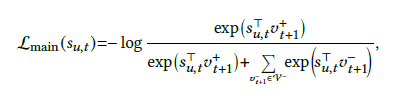

- 최종 Losss는 Next item Prediction Loss에 Contrastive loss를 일정 비율로 추가함

### Dataset
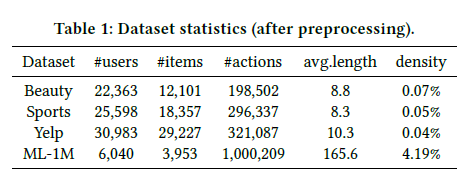

- 5점 척도 데이터셋은 5점만 interation으로 간주
- 나머지 데이터셋은 실제 리뷰를 통해 interation 여부 판단
- ML-1M : 상당히 Dense 한 경우
- Min length : 5

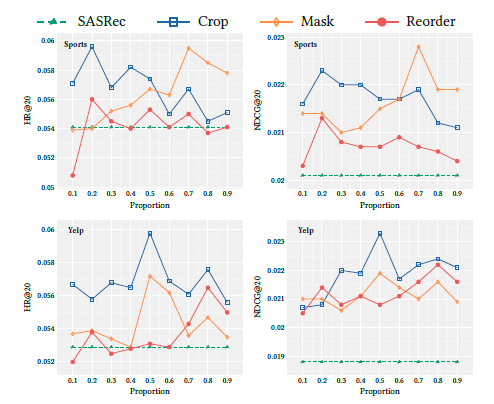

- 각 Augmentation 마다 데이터셋에 따라 가장 좋은 방법이 다름 -> 각각의 방식이 Raw data에서 뽑고자 하는 정보가 다르다는 뜻
- 일반적으로 적절한 비율을 선택 시 CL Loss를 사용하는 것이 그렇지 않은 것 보다 좋은 성능을 보임

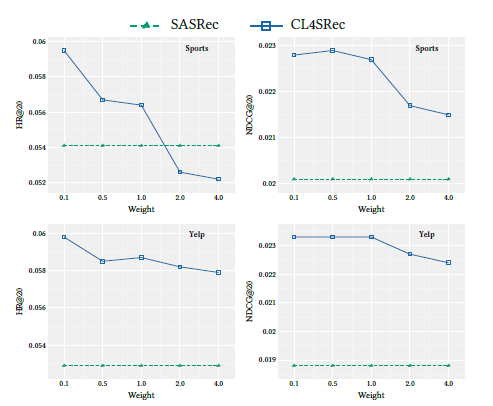

- 일반적으로 CL Loss 사용하는 것이 적절한 비율에서는 좋음
- 과도하게 큰 비율은 성능 저하를 야기한다.

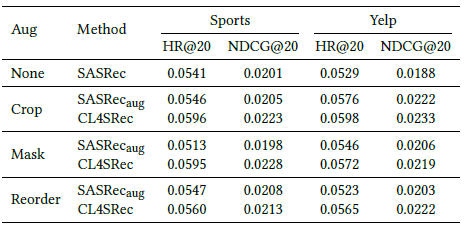
- SASRec에 Augmentation 방식을 추가로 학습(DA관점)
- DA고나점에서도 성능 향상
- CL LOSS까지 적용한다면 더 좋아질 것으로 예상

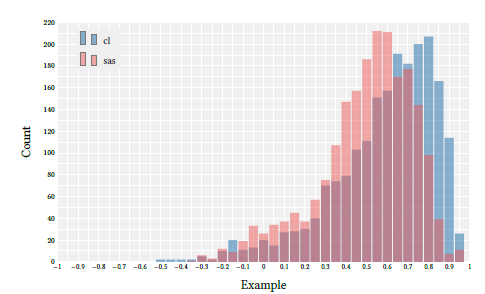

### Last item representation이 과연 User의 특성을 나타내는가?

- Yelp 데이터셋에서 친구 여부를 확인 후 학습된 User Representation의 유사도 계산
- 친구는 서로 같은 관심사를 공유한다는 전제
- CL4SRex모델이 SASRec보다 더 높은 유사도 수치를 보임